
# Explainable AI

[作業說明投影片](https://docs.google.com/presentation/d/13xUwWArz0LROgyJBwGCf1Vili5u7l4K6WcyuRxxakAo/)

[Homework Introduction](https://docs.google.com/presentation/d/13xUwWArz0LROgyJBwGCf1Vili5u7l4K6WcyuRxxakAo/)

本作業不提供 python script 版本

There is no python script version for this homework

若有任何問題，歡迎來信至助教信箱： ntu-ml-2021spring-ta@googlegroups.com

If you have any question, TA's mail: ntu-ml-2021spring-ta@googlegroups.com

## Deadline

- Mandarin/English: 5/7 release, 5/28 submit

# **Homework 9 - Explainable AI (Part 1 CNN)**

Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os
os.chdir('gdrive/MyDrive/ML_hw9')
!ls

checkpoint.pth	food  food.zip	hw9_bert  hw9_bert.zip	taipei_sans_tc_beta.ttf


## Environment settings

In [ ]:
# download and unzip training data
#!gdown --id '1cYBWwYab3djiaYuOU6CxkYHQyUYws4Ce' --output food.zip
#!unzip food.zip

In [ ]:
# download pretrained model
#!gdown --id '1CShZHsO8oAZwxQkMe7jRtEgSNb2w_OZu' --output checkpoint.pth

In [ ]:
# install lime in colab
!pip install lime==0.1.1.37

## Start our python script

In [ ]:
import os
import sys
import argparse
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from skimage.segmentation import slic
from lime import lime_image
from pdb import set_trace
from torch.autograd import Variable

## Argument parsing

In [ ]:
args = {
      'ckptpath': './checkpoint.pth',
      'dataset_dir': './food/'
}
args = argparse.Namespace(**args)

## Model definition and checkpoint loading

In [ ]:
# Model definition
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()

    def building_block(indim, outdim):
      return [
        nn.Conv2d(indim, outdim, 3, 1, 1),
        nn.BatchNorm2d(outdim),
        nn.ReLU(),
      ]
    def stack_blocks(indim, outdim, block_num):
      layers = building_block(indim, outdim)
      for i in range(block_num - 1):
        layers += building_block(outdim, outdim)
      layers.append(nn.MaxPool2d(2, 2, 0))
      return layers

    cnn_list = []
    cnn_list += stack_blocks(3, 128, 3)
    cnn_list += stack_blocks(128, 128, 3)
    cnn_list += stack_blocks(128, 256, 3)
    cnn_list += stack_blocks(256, 512, 1)
    cnn_list += stack_blocks(512, 512, 1)
    self.cnn = nn.Sequential( * cnn_list)

    dnn_list = [
      nn.Linear(512 * 4 * 4, 1024),
      nn.ReLU(),
      nn.Dropout(p = 0.3),
      nn.Linear(1024, 11),
    ]
    self.fc = nn.Sequential( * dnn_list)

  def forward(self, x):
    out = self.cnn(x)
    out = out.reshape(out.size()[0], -1)
    return self.fc(out)

In [ ]:
# Load trained model
model = Classifier().cuda()
checkpoint = torch.load(args.ckptpath)
model.load_state_dict(checkpoint['model_state_dict'])
# It should display: <All keys matched successfully> 

<All keys matched successfully>

## Dataset definition and creation

In [ ]:
# It might take some time, if it is too long, try to reload it.
# Dataset definition
class FoodDataset(Dataset):
    def __init__(self, paths, labels, mode):
        # mode: 'train' or 'eval'
        
        self.paths = paths
        self.labels = labels
        trainTransform = transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
        ])
        evalTransform = transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.ToTensor(),
        ])
        self.transform = trainTransform if mode == 'train' else evalTransform

    # pytorch dataset class
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        X = Image.open(self.paths[index])
        X = self.transform(X)
        Y = self.labels[index]
        return X, Y

    # help to get images for visualizing
    def getbatch(self, indices):
        images = []
        labels = []
        for index in indices:
          image, label = self.__getitem__(index)
          images.append(image)
          labels.append(label)
        return torch.stack(images), torch.tensor(labels)

# help to get data path and label
def get_paths_labels(path):
    def my_key(name):
      return int(name.replace(".jpg",""))+1000000*int(name.split("_")[0])
    imgnames = os.listdir(path)
    imgnames.sort(key=my_key)
    imgpaths = []
    labels = []
    for name in imgnames:
        imgpaths.append(os.path.join(path, name))
        labels.append(int(name.split('_')[0]))
    return imgpaths, labels
train_paths, train_labels = get_paths_labels(args.dataset_dir)

train_set = FoodDataset(train_paths, train_labels, mode='eval')

## Start XAI Homework

## The images for observation

There are 11 categories of food: Bread, Dairy product, Dessert, Egg, Fried food, Meat, Noodles/Pasta, Rice, Seafood, Soup, and Vegetable/Fruit.

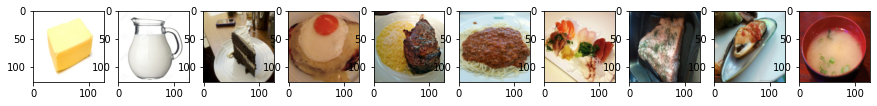

In [ ]:
img_indices = [i for i in range(10)]
images, labels = train_set.getbatch(img_indices)
fig, axs = plt.subplots(1, len(img_indices), figsize=(15, 8))
for i, img in enumerate(images):
  axs[i].imshow(img.cpu().permute(1, 2, 0))
# print(labels)

## Lime

[Lime](https://github.com/marcotcr/lime.git) is a package about explaining what machine learning classifiers are doing. We can first use it to observe the model.

In [ ]:
def predict(input):
    # input: numpy array, (batches, height, width, channels)                                                                                                                                                     
    
    model.eval()                                                                                                                                                             
    input = torch.FloatTensor(input).permute(0, 3, 1, 2)                                                                                                            
    # pytorch tensor, (batches, channels, height, width)

    output = model(input.cuda())                                                                                                                                             
    return output.detach().cpu().numpy()                                                                                                                              
                                                                                                                                                                             
def segmentation(input):
    # split the image into 200 pieces with the help of segmentaion from skimage                                                                                                                   
    return slic(input, n_segments=200, compactness=1, sigma=1)                                                                                                              
                                                                                                                                                                             

fig, axs = plt.subplots(1, len(img_indices), figsize=(15, 8))                                                                                                                                                                 
# fix the random seed to make it reproducible
np.random.seed(16)                                                                                                                                                       
for idx, (image, label) in enumerate(zip(images.permute(0, 2, 3, 1).numpy(), labels)):                                                                                                                                             
    x = image.astype(np.double)
    # numpy array for lime

    explainer = lime_image.LimeImageExplainer()                                                                                                                              
    explaination = explainer.explain_instance(image=x, classifier_fn=predict, segmentation_fn=segmentation)

    # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=explain_instance#lime.lime_image.LimeImageExplainer.explain_instance

    lime_img, mask = explaination.get_image_and_mask(                                                                                                                         
                                label=label.item(),                                                                                                                           
                                positive_only=False,                                                                                                                         
                                hide_rest=False,                                                                                                                             
                                num_features=11,                                                                                                                              
                                min_weight=0.05                                                                                                                              
                            )
    # turn the result from explainer to the image
    # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=get_image_and_mask#lime.lime_image.ImageExplanation.get_image_and_mask
    
    axs[idx].imshow(lime_img)

plt.show()
plt.close()

### What is Saliency map
Saliency: 顯著性

The heatmaps that highlight pixels of the input image that contribute the most in the classification task. 

Ref: https://medium.com/datadriveninvestor/visualizing-neural-networks-using-saliency-maps-in-pytorch-289d8e244ab4

### Saliency map

We put an image into the model, forward then calculate the loss referring to the label. Therefore, the loss is related to:
- image
- model parameters
- label

Generally speaking, we change model parameters to fit "image" and "label". When backward, we calculate the partial differential value of **loss to model parameters**. 

Now, we have another look. When we change the image's pixel value, the partial differential value of **loss to image** shows the change in the loss. We can say that it means the importance of the pixel. We can visualize it to demonstrate which part of the image contribute the most to the model's judgement.

In [ ]:
def normalize(image):
  return (image - image.min()) / (image.max() - image.min())
  # return torch.log(image)/torch.log(image.max())

def compute_saliency_maps(x, y, model):
  model.eval()
  x = x.cuda()

  # we want the gradient of the input x
  x.requires_grad_()
  
  y_pred = model(x)
  loss_func = torch.nn.CrossEntropyLoss()
  loss = loss_func(y_pred, y.cuda())
  loss.backward()

  # saliencies = x.grad.abs().detach().cpu()
  saliencies, _ = torch.max(x.grad.data.abs().detach().cpu(),dim=1)

  # We need to normalize each image, because their gradients might vary in scale, but we only care about the relation in each image
  saliencies = torch.stack([normalize(item) for item in saliencies])
  return saliencies

In [ ]:
# images, labels = train_set.getbatch(img_indices)
saliencies = compute_saliency_maps(images, labels, model)

# visualize
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for row, target in enumerate([images, saliencies]):
  for column, img in enumerate(target):
    if row==0:
      axs[row][column].imshow(img.permute(1, 2, 0).numpy())
      # What is permute?
      # In pytorch, the meaning of each dimension of image tensor is (channels, height, width)
      # In matplotlib, the meaning of each dimension of image tensor is (height, width, channels)
      # permute is a tool for permuting dimensions of tensors
      # For example, img.permute(1, 2, 0) means that,
      # - 0 dimension is the 1 dimension of the original tensor, which is height
      # - 1 dimension is the 2 dimension of the original tensor, which is width
      # - 2 dimension is the 0 dimension of the original tensor, which is channels
    else:
      axs[row][column].imshow(img.numpy(), cmap=plt.cm.hot)
    
plt.show()
plt.close()

### Smooth grad

Smooth grad 的方法是，在圖片中隨機地加入 noise，然後得到不同的 heatmap，把這些 heatmap 平均起來就得到一個比較能抵抗 noisy gradient 的結果。

The method of Smooth grad is randomly adding noise to the image and get different heatmaps. The average of the heatmaps would be more robust to noisy gradient.

ref: https://arxiv.org/pdf/1706.03825.pdf

In [ ]:
# Smooth grad

def normalize(image):
  return (image - image.min()) / (image.max() - image.min())

def smooth_grad(x, y, model, epoch, param_sigma_multiplier):
  model.eval()
  #x = x.cuda().unsqueeze(0)

  mean = 0
  sigma = param_sigma_multiplier / (torch.max(x) - torch.min(x)).item()
  smooth = np.zeros(x.cuda().unsqueeze(0).size())
  for i in range(epoch):
    # call Variable to generate random noise
    noise = Variable(x.data.new(x.size()).normal_(mean, sigma**2))
    x_mod = (x+noise).unsqueeze(0).cuda()
    x_mod.requires_grad_()

    y_pred = model(x_mod)
    loss_func = torch.nn.CrossEntropyLoss()
    loss = loss_func(y_pred, y.cuda().unsqueeze(0))
    loss.backward()

    # like the method in saliency map
    smooth += x_mod.grad.abs().detach().cpu().data.numpy()
  smooth = normalize(smooth / epoch) # don't forget to normalize
  #smooth = smooth / epoch
  return smooth

# images, labels = train_set.getbatch(img_indices)
smooth = []
for i, l in zip(images, labels):
  smooth.append(smooth_grad(i, l, model, 500, 0.4))
smooth = np.stack(smooth)
print(smooth.shape)

fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for row, target in enumerate([images, smooth]):
  for column, img in enumerate(target):
    axs[row][column].imshow(np.transpose(img.reshape(3,128,128), (1,2,0)))




## Filter explanation

這裡我們想要知道某一個 filter 到底認出了什麼。我們會做以下兩件事情：
- Filter activation: 挑幾張圖片出來，看看圖片中哪些位置會 activate 該 filter
- Filter visualization: 怎樣的 image 可以最大程度的 activate 該 filter

In this part, we want to know what a specific filter recognize, we'll do
- Filter activation: pick up some images, check which part of the image will activate the filter
- Filter visualization: which kind of image can activate the filter the most

實作上比較困難的地方是，通常我們是直接把 image 丟進 model，一路 forward 到底。如：

The problem is that, in normal case, we'll directly feed the image to the model, for example,
```
loss = model(image)
loss.backward()
```
我們要怎麼得到中間某層 CNN 的 output? 當然我們可以直接修改 model definition，讓 forward 不只 return loss，也 return activation map。但這樣的寫法麻煩了，更改了 forward 的 output 可能會讓其他部分的 code 要跟著改動。因此 pytorch 提供了方便的 solution: **hook**，以下我們會再介紹。

How can we get the output of a specific layer of CNN? We can modify the model definition, make the forward function not only return loss but also retrun the activation map. But this is difficult to maintain the code. As a result, pytorch offers a better solution: **hook**


In [ ]:
model

In [ ]:
def normalize(image):
  return (image - image.min()) / (image.max() - image.min())

layer_activations = None
def filter_explanation(x, model, cnnid, filterid, iteration=100, lr=1):
  # x: input image
  # cnnid, filterid: cnn layer id, which filter
  model.eval()

  def hook(model, input, output):
    global layer_activations
    layer_activations = output
  
  hook_handle = model.cnn[cnnid].register_forward_hook(hook)
  # When the model forward through the layer[cnnid], need to call the hook function first
  # The hook function save the output of the layer[cnnid]
  # After forwarding, we'll have the loss and the layer activation

  # Filter activation: x passing the filter will generate the activation map
  model(x.cuda()) # forward

  # Based on the filterid given by the function argument, pick up the specific filter's activation map
  # We just need to plot it, so we can detach from graph and save as cpu tensor
  filter_activations = layer_activations[:, filterid, :, :].detach().cpu()
  
  # Filter visualization: find the image that can activate the filter the most
  x = x.cuda()
  x.requires_grad_()
  # input image gradient
  optimizer = Adam([x], lr=lr)
  # Use optimizer to modify the input image to amplify filter activation
  for iter in range(iteration):
    optimizer.zero_grad()
    model(x)
    
    objective = -layer_activations[:, filterid, :, :].sum()
    # We want to maximize the filter activation's summation
    # So we add a negative sign
    
    objective.backward()
    # Calculate the partial differential value of filter activation to input image
    optimizer.step()
    # Modify input image to maximize filter activation
  filter_visualizations = x.detach().cpu().squeeze()

  # Don't forget to remove the hook
  hook_handle.remove()
  # The hook will exist after the model register it, so you have to remove it after used
  # Just register a new hook if you want to use it

  return filter_activations, filter_visualizations

In [ ]:
images, labels = train_set.getbatch(img_indices)
filter_activations, filter_visualizations = filter_explanation(images, model, cnnid=6, filterid=0, iteration=100, lr=0.1)


fig, axs = plt.subplots(3, len(img_indices), figsize=(15, 8))
for i, img in enumerate(images):
  axs[0][i].imshow(img.permute(1, 2, 0))
# Plot filter activations
for i, img in enumerate(filter_activations):
  axs[1][i].imshow(normalize(img))
# Plot filter visualization
for i, img in enumerate(filter_visualizations):
  axs[2][i].imshow(normalize(img.permute(1, 2, 0)))
plt.show()
plt.close()

# 從下面四張圖可以看到，activate 的區域對應到一些物品的邊界，尤其是顏色對比較深的邊界

In [ ]:
images, labels = train_set.getbatch(img_indices)
filter_activations, filter_visualizations = filter_explanation(images, model, cnnid=23, filterid=0, iteration=100, lr=0.1)

# Plot filter activations
fig, axs = plt.subplots(3, len(img_indices), figsize=(15, 8))
for i, img in enumerate(images):
  axs[0][i].imshow(img.permute(1, 2, 0))
for i, img in enumerate(filter_activations):
  axs[1][i].imshow(normalize(img))
for i, img in enumerate(filter_visualizations):
  axs[2][i].imshow(normalize(img.permute(1, 2, 0)))
plt.show()
plt.close()


In [ ]:
images, labels = train_set.getbatch(img_indices)
filter_activations, filter_visualizations = filter_explanation(images, model, cnnid=15, filterid=0, iteration=100, lr=0.1)

# Plot filter activations
fig, axs = plt.subplots(3, len(img_indices), figsize=(15, 8))
for i, img in enumerate(images):
  axs[0][i].imshow(img.permute(1, 2, 0))
for i, img in enumerate(filter_activations):
  axs[1][i].imshow(normalize(img))
for i, img in enumerate(filter_visualizations):
  axs[2][i].imshow(normalize(img.permute(1, 2, 0)))
plt.show()
plt.close()


## Integrated Gradient



In [ ]:
class IntegratedGradients():
    def __init__(self, model):
        self.model = model
        self.gradients = None
        # Put model in evaluation mode
        self.model.eval()

    def generate_images_on_linear_path(self, input_image, steps):
        # Generate scaled xbar images
        xbar_list = [input_image*step/steps for step in range(steps)]
        return xbar_list

    def generate_gradients(self, input_image, target_class):
        # We want to get the gradients of the input image
        input_image.requires_grad=True
        # Forward
        model_output = self.model(input_image)
        # Zero grads
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_().cuda()
        one_hot_output[0][target_class] = 1
        # Backward
        model_output.backward(gradient=one_hot_output)
        self.gradients = input_image.grad
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,128,128)
        gradients_as_arr = self.gradients.data.cpu().numpy()[0]
        return gradients_as_arr

    def generate_integrated_gradients(self, input_image, target_class, steps):
        # Generate xbar images
        xbar_list = self.generate_images_on_linear_path(input_image, steps)
        # Initialize an iamge composed of zeros
        integrated_grads = np.zeros(input_image.size())
        for xbar_image in xbar_list:
            # Generate gradients from xbar images
            single_integrated_grad = self.generate_gradients(xbar_image, target_class)
            # Add rescaled grads from xbar images
            integrated_grads = integrated_grads + single_integrated_grad/steps
        # [0] to get rid of the first channel (1,3,128,128)
        return integrated_grads[0]

def normalize(image):
  return (image - image.min()) / (image.max() - image.min())

In [ ]:
# put the image to cuda
images, labels = train_set.getbatch(img_indices)
images = images.cuda()

In [ ]:
IG = IntegratedGradients(model)
integrated_grads = []
for i, img in enumerate(images):
  img = img.unsqueeze(0)
  integrated_grads.append(IG.generate_integrated_gradients(img, labels[i], 10))
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for i, img in enumerate(images):
  axs[0][i].imshow(img.cpu().permute(1, 2, 0))
for i, img in enumerate(integrated_grads):
  axs[1][i].imshow(np.moveaxis(normalize(img),0,-1))
plt.show()
plt.close()

In [ ]:
IG = IntegratedGradients(model)
integrated_grads = []
for i, img in enumerate(images):
  img = img.unsqueeze(0)
  integrated_grads.append(IG.generate_integrated_gradients(img, labels[i], 100))
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for i, img in enumerate(images):
  axs[0][i].imshow(img.cpu().permute(1, 2, 0))
for i, img in enumerate(integrated_grads):
  axs[1][i].imshow(np.moveaxis(normalize(img),0,-1))
plt.show()
plt.close()

# **Homework 9 - Explainable AI (Part 2 BERT)**


# Question 21 - 24
### You are recommended to visualize on this website directly: https://exbert.net/exBERT.html

In [ ]:
from IPython import display
display.IFrame("https://exbert.net/exBERT.html", width=1600, height=1600)

# Import Packages (For Questions 25 - 30)

In [ ]:
# Install transformers
!pip install transformers==4.5.0

# Import all packages needed
import numpy as np
import random
import torch

from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from transformers import BertModel, BertTokenizerFast

##### For Displaying Traditional Chinese in Colab when Drawing with Matplotlib #####
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!gdown --id '1WOjwyN_wimGfrw0kE2nvp6OxFimch3H5' --output taipei_sans_tc_beta.ttf

from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt 

# 自定義字體變數
myfont = FontProperties(fname=r'taipei_sans_tc_beta.ttf')

# !!!!後續在相關函式中增加fontproperties=myfont屬性即可!!!!
##### Code from https://colab.research.google.com/github/willismax/matplotlib_show_chinese_in_colab/blob/master/matplotlib_show_chinese_in_colab.ipynb #####

plt.rcParams['figure.figsize'] = [12, 10]

# Fix random seed for reproducibility
def same_seeds(seed):
	torch.manual_seed(seed)
	if torch.cuda.is_available():
		torch.cuda.manual_seed(seed)
		torch.cuda.manual_seed_all(seed)
	np.random.seed(seed)
	random.seed(seed)
	torch.backends.cudnn.benchmark = False
	torch.backends.cudnn.deterministic = True

same_seeds(0)

Downloading...
From: https://drive.google.com/uc?id=1WOjwyN_wimGfrw0kE2nvp6OxFimch3H5
To: /content/gdrive/My Drive/ML_hw9/taipei_sans_tc_beta.ttf
20.7MB [00:00, 126MB/s]


# Question 25 - 27

## Visualizing Bert's embedding


#### Tom has 3 pretrained models, but he is not sure which of these models has been fine-tuned for Question Answering. 

His instinct told him solving QA requires 4 steps:　(steps are **NOT** in order since he has such a bad memory)

1. Clustering similar words together (based on relation of words in context)

2. Answer extraction

3. Clustering similar words together (based on meaning of words)

4. Matching question with relevant information in context


#### Can you help him solve this problem just by looking into the embedding of hidden states?

<br>

#### 湯姆有 3 個預訓練模型，但他忘記每一個模型是否有微調在閱讀理解的任務上了。

他的直覺告訴他解閱讀理解需要四個步驟﹕（因為他很健忘，所以這些步驟並**不**按照順序排列)

1. 將類似的文字分羣 (根據文字在文章中的關係)

2. 提取答案

3. 將類似的文字分羣 (根據文字的意思)

4. 從文章中尋找與問題有關的資訊

#### 你可以在只看見模型 hidden states embedding 的情況下，幫湯姆解決這個問題嗎?



## Download Tokenizers and Models' hidden states

In [ ]:
!gdown --id '17AZ2KAUFpYHJOC0DHet3cQWYE5sX2yxo' --output hw9_bert.zip
!unzip hw9_bert.zip

Downloading...
From: https://drive.google.com/uc?id=17AZ2KAUFpYHJOC0DHet3cQWYE5sX2yxo
To: /content/gdrive/My Drive/ML_hw9/hw9_bert.zip
28.1MB [00:00, 132MB/s] 
Archive:  hw9_bert.zip
replace hw9_bert/tokenizer1/tokenizer_config.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: hw9_bert/tokenizer1/tokenizer_config.json  
replace hw9_bert/tokenizer1/special_tokens_map.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: hw9_bert/tokenizer1/special_tokens_map.json  
replace hw9_bert/tokenizer1/vocab.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: hw9_bert/tokenizer1/vocab.txt  
  inflating: hw9_bert/tokenizer2/vocab.txt  
  inflating: hw9_bert/tokenizer2/special_tokens_map.json  
  inflating: hw9_bert/tokenizer2/tokenizer_config.json  
  inflating: hw9_bert/tokenizer3/tokenizer_config.json  
  inflating: hw9_bert/tokenizer3/special_tokens_map.json  
  inflating: hw9_bert/tokenizer3/vocab.txt  
  inflating: hw9_bert/output/model1_q1  
  inflating: hw9_bert/output/m

## Load Tokenizers

In [ ]:
tokenizer1 = BertTokenizerFast.from_pretrained("hw9_bert/tokenizer1")
tokenizer2 = BertTokenizerFast.from_pretrained("hw9_bert/tokenizer2")
tokenizer3 = BertTokenizerFast.from_pretrained("hw9_bert/tokenizer3")
tokenizers = [tokenizer1, tokenizer2, tokenizer3]

## What to Visualize?

In [ ]:
contexts, questions, answers = [], [], []

# Question 1
contexts += ['Currently detention is one of the most common punishments in schools in the United States, the UK, Ireland, Singapore and other countries. \
            It requires the pupil to remain in school at a given time in the school day (such as lunch, recess or after school); or even to attend \
            school on a non-school day, e.g. "Saturday detention" held at some schools. During detention, students normally have to sit in a classroom \
            and do work, write lines or a punishment essay, or sit quietly.']
questions += ['What is a common punishment in the UK and Ireland?']
answers += ['detention']

# Question 2
contexts += ['Wolves are afraid of cats. Sheep are afraid of wolves. Mice are afraid of sheep. Gertrude is a mouse. Jessica is a mouse. \
            Emily is a wolf. Cats are afraid of sheep. Winona is a wolf.']
questions += ['What is Emily afraid of?']
answers += ['cats']

# Question 3
contexts += ["Nikola Tesla (Serbian Cyrillic: Никола Тесла; 10 July 1856 – 7 January 1943) was a Serbian American inventor, electrical engineer, \
            mechanical engineer, physicist, and futurist best known for his contributions to the design of the modern alternating current \
            (AC) electricity supply system."]
questions += ["In what year was Nikola Tesla born?"]
answers += ["1856"]

## TODO

In [ ]:
# Choose from 1, 2, 3
MODEL = 1

# Choose from 1, 2, 3
QUESTION = 1

## Visualization

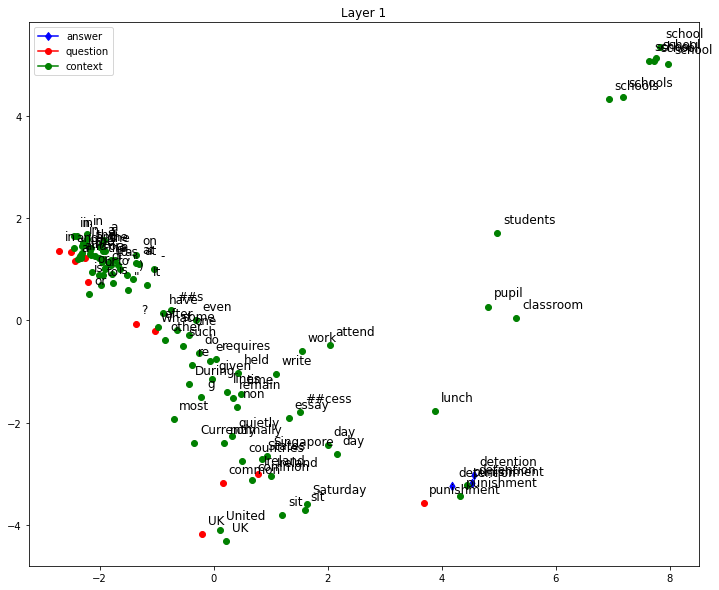

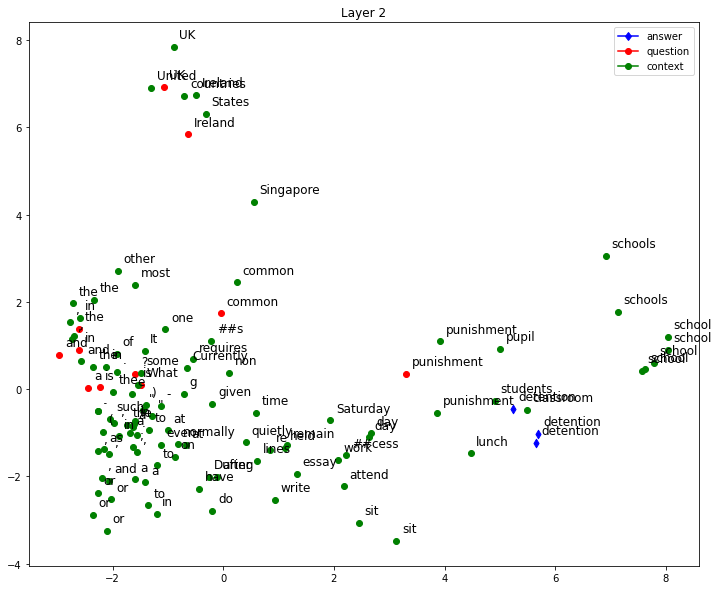

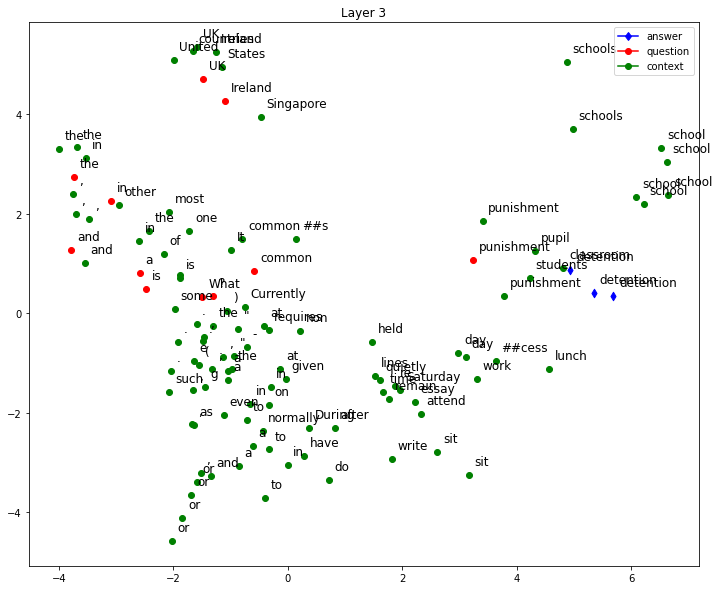

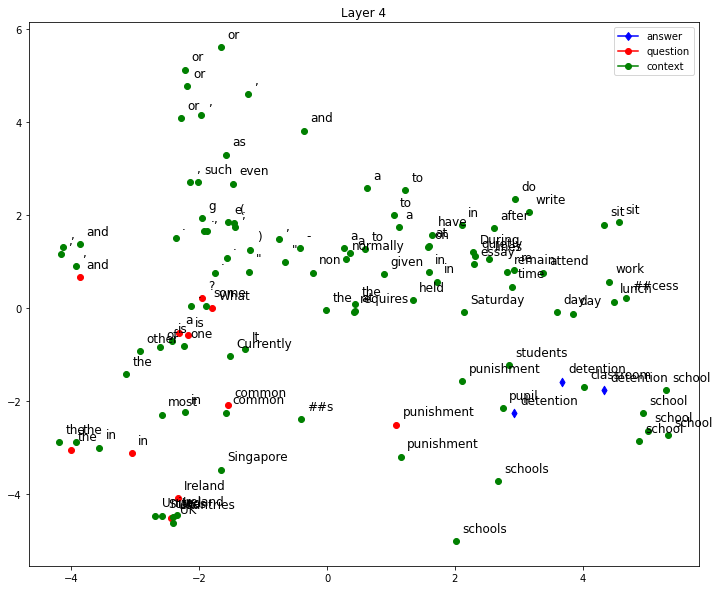

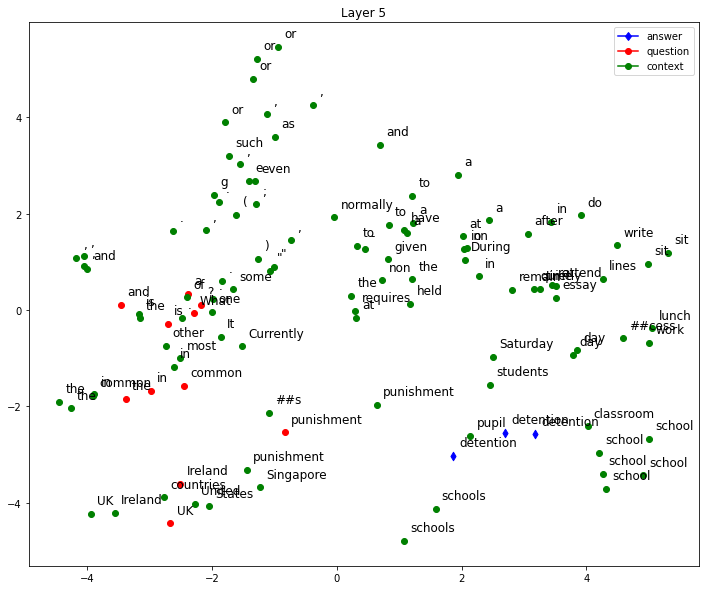

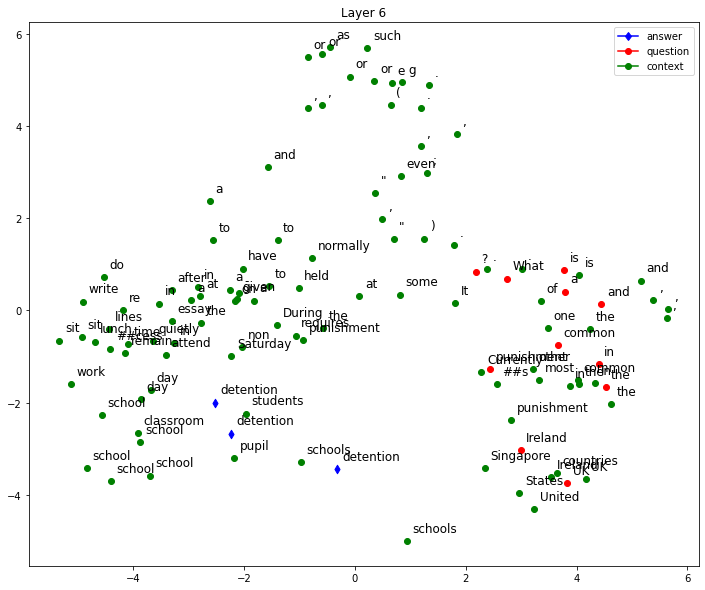

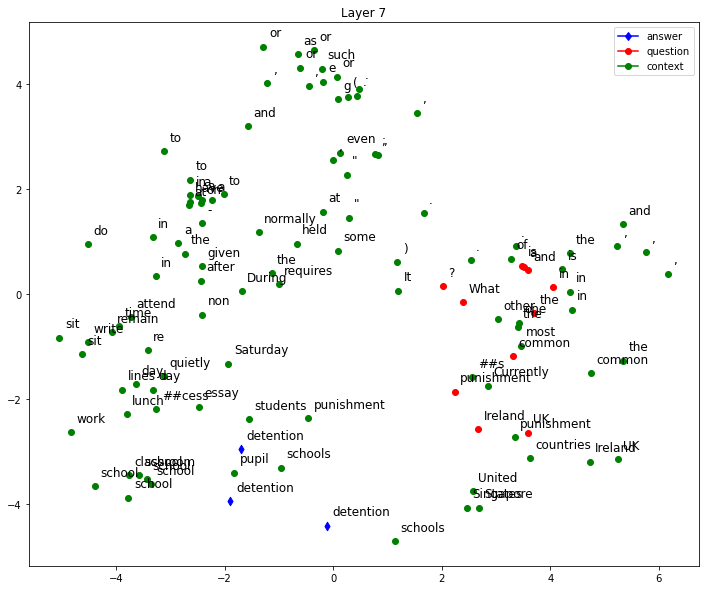

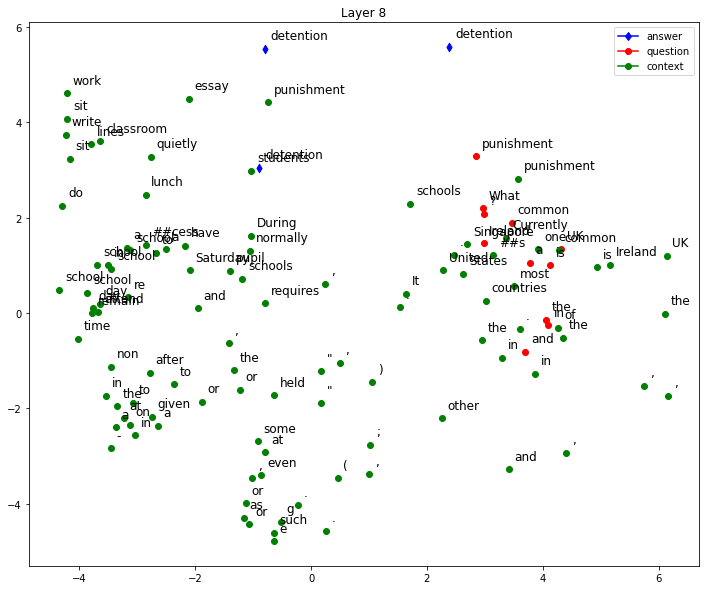

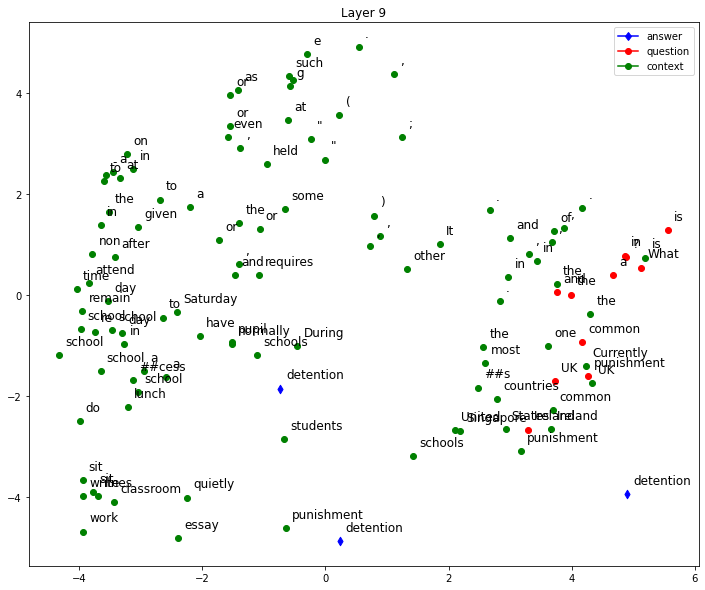

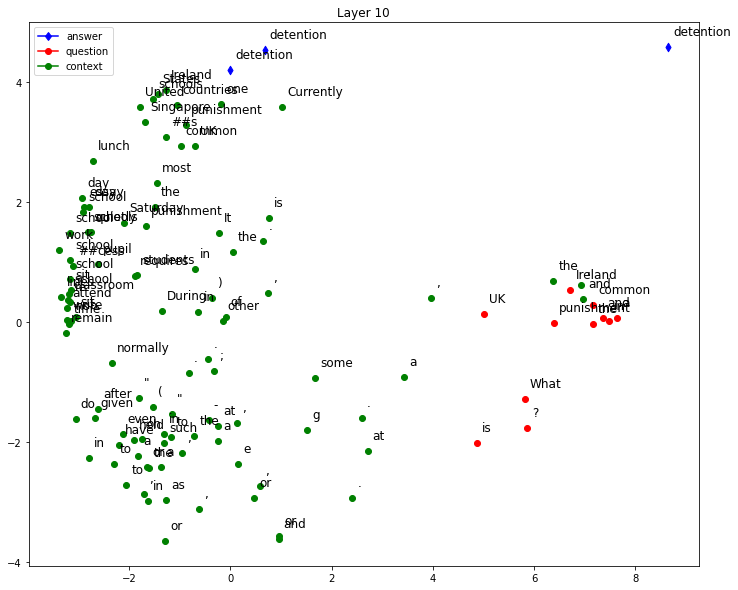

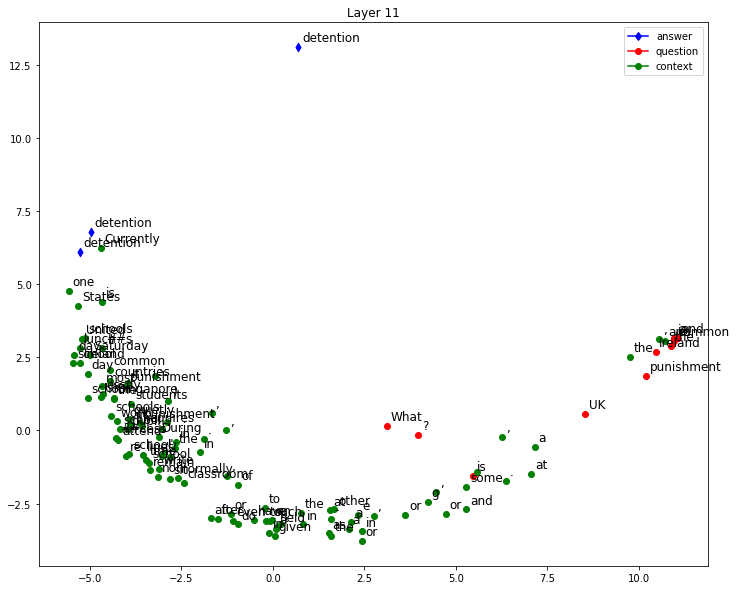

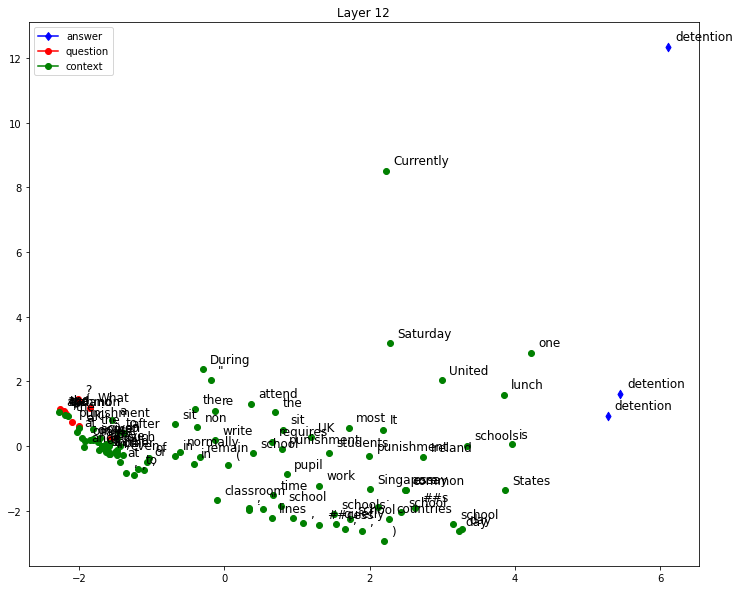

In [ ]:
# Tokenize and encode question and paragraph into model's input format
inputs = tokenizers[MODEL-1](questions[QUESTION-1], contexts[QUESTION-1], return_tensors='pt') 

# Get the [start, end] positions of [question, context] in encoded sequence for plotting
question_start, question_end = 1, inputs['input_ids'][0].tolist().index(102) - 1
context_start, context_end = question_end + 2, len(inputs['input_ids'][0]) - 2

outputs_hidden_states = torch.load(f"hw9_bert/output/model{MODEL}_q{QUESTION}")

##### Traverse hidden state of all layers #####
# "outputs_hidden_state" is a tuple with 13 elements, the 1st element is embedding output, the other 12 elements are attention hidden states of layer 1 - 12
for layer_index, embeddings in enumerate(outputs_hidden_states[1:]): # 1st element is skipped
 
    # "embeddings" has shape [1, sequence_length, 768], where 768 is the dimension of BERT's hidden state
    # Dimension of "embeddings" is reduced from 768 to 2 using PCA (Principal Component Analysis)
    reduced_embeddings = PCA(n_components=2, random_state=0).fit_transform(embeddings[0])

    ##### Draw embedding of each token ##### 
    for i, token_id in enumerate(inputs['input_ids'][0]):
        x, y = reduced_embeddings[i] # Embedding has 2 dimensions, each corresponds to a point
        word = tokenizers[MODEL-1].decode(token_id) # Decode token back to word
        # Scatter points of answer, question and context in different colors
        if word in answers[QUESTION-1].split(): # Check if word in answer
            plt.scatter(x, y, color='blue', marker='d') 
        elif question_start <= i <= question_end:
            plt.scatter(x, y, color='red')
        elif context_start <= i <= context_end:
            plt.scatter(x, y, color='green')
        else: # skip special tokens [CLS], [SEP]
            continue
        plt.text(x + 0.1, y + 0.2, word, fontsize=12) # Plot word next to its point
    
    # Plot "empty" points to show labels
    plt.plot([], label='answer', color='blue', marker='d')  
    plt.plot([], label='question', color='red', marker='o')
    plt.plot([], label='context', color='green', marker='o')
    plt.legend(loc='best') # Display the area describing the elements in the plot
    plt.title('Layer ' + str(layer_index + 1)) # Add title to the plot
    plt.show() # Show the plot

# Question 28 - 30

## Comparing Bert's embedding


### Load Model

In [ ]:
model = BertModel.from_pretrained('bert-base-chinese', output_hidden_states=True).eval()
tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')

### What to Visualize?

In [ ]:
# Sentences for visualization
sentences = []
sentences += ["今天買了蘋果來吃"]
sentences += ["進口蘋果（富士)平均每公斤下跌12.3%"]
sentences += ["蘋果茶真難喝"]
sentences += ["老饕都知道智利的蘋果季節即將到來"]
sentences += ["進口蘋果因防止水分流失故添加人工果糖"]
sentences += ["蘋果即將於下月發振新款iPhone"]
sentences += ["蘋果獲新Face ID專利"]
sentences += ["今天買了蘋果手機"]
sentences += ["蘋果的股價又跌了"]
sentences += ["蘋果押寶指紋辨識技術"]

# Index of word selected for embedding comparison. E.g. For sentence "蘋果茶真難喝", if index is 0, "蘋 is selected"
select_word_index = [4, 2, 0, 8, 2, 0, 0, 4, 0, 0] #蘋
#select_word_index = [5, 3, 1, 9, 3, 1, 1, 5, 1, 1] #果

### TODO

In [ ]:
def euclidean_distance(a, b):
    # Compute euclidean distance (L2 norm) between two numpy vectors a and b
    return np.linalg.norm(a-b)

def cosine_similarity(a, b):
    # Compute cosine similarity between two numpy vectors a and b
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

# Metric for comparison. Choose from euclidean_distance, cosine_similarity
METRIC = cosine_similarity

def get_select_embedding(output, tokenized_sentence, select_word_index):
    # The layer to visualize, choose from 0 to 12
    LAYER = 11
    # Get selected layer's hidden state
    hidden_state = output.hidden_states[LAYER][0]
    # Convert select_word_index in sentence to select_token_index in tokenized sentence
    select_token_index = tokenized_sentence.word_to_tokens(select_word_index).start
    # Return embedding of selected word
    return hidden_state[select_token_index].numpy()

### Visualization

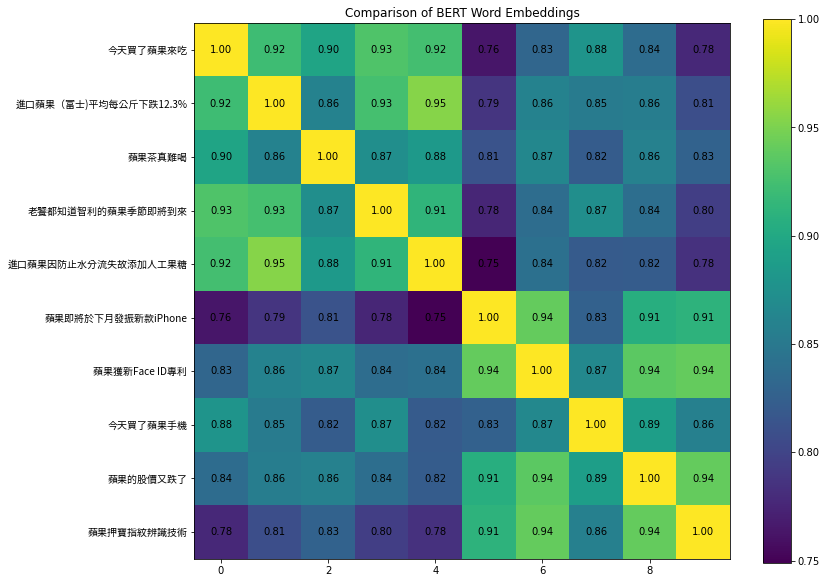

In [ ]:
# Tokenize and encode sentences into model's input format
tokenized_sentences = [tokenizer(sentence, return_tensors='pt') for sentence in sentences]

# Input encoded sentences into model and get outputs 
with torch.no_grad():
    outputs = [model(**tokenized_sentence) for tokenized_sentence in tokenized_sentences]

# Get embedding of selected word(s) in sentences. "embeddings" has shape (len(sentences), 768), where 768 is the dimension of BERT's hidden state
embeddings = [get_select_embedding(outputs[i], tokenized_sentences[i], select_word_index[i]) for i in range(len(outputs))]

# Pairwse comparsion of sentences' embeddings using the metirc defined. "similarity_matrix" has shape [len(sentences), len(sentences)]
similarity_matrix = pairwise_distances(embeddings, metric=METRIC) 

##### Plot the similarity matrix #####
plt.rcParams['figure.figsize'] = [12, 10] # Change figure size of the plot
plt.imshow(similarity_matrix) # Display an image in the plot
plt.colorbar() # Add colorbar to the plot
plt.yticks(ticks=range(len(sentences)), labels=sentences, fontproperties=myfont) # Set tick locations and labels (sentences) of y-axis
plt.title('Comparison of BERT Word Embeddings') # Add title to the plot
for (i,j), label in np.ndenumerate(similarity_matrix): # np.ndenumerate is 2D version of enumerate
    plt.text(i, j, '{:.2f}'.format(label), ha='center', va='center') # Add values in similarity_matrix to the corresponding position in the plot
plt.show() # Show the plot 